In [38]:
import pandas as pd
import numpy as np

In [39]:
data = pd.read_csv('./aave_barrow_contract.csv')
df = data.copy()

In [40]:
df.head()

,Txhash,Blockno,UnixTimestamp,DateTime,From,To,ContractAddress,Value_IN(ETH),Value_OUT(ETH),CurrentValue @ $1869.43/Eth,TxnFee(ETH),TxnFee(USD),Historical $Price/Eth,Method
0,0xa23b260fa3ec2677889587a5bc72e843ae6f39e5adf1...,22104765,1662458272,06/09/2022 09:57,0x4365f8e70cf38c6ca67de41448508f2da8825500,NaN,0x76d3030728e52deb8848d5613abade88441cbc59,0.000000,0,0.00000,0.000730,1.364804,1558.9,0x60c06040
1,0x64b50ed929f06e574dc0dbfbaae11905e171878b15af...,22154621,1662483310,06/09/2022 16:55,0xd53c79ff8c473bbfe4e40e5525d4d24fd4b8534c,0x76d3030728e52deb8848d5613abade88441cbc59,NaN,0.000000,0,0.00000,0.000097,0.180834,1558.9,Withdraw ETH
2,0x650a432506ecd60e6b968469f9e09f9d35826e33015d...,22154653,1662483341,06/09/2022 16:55,0xd53c79ff8c473bbfe4e40e5525d4d24fd4b8534c,0x76d3030728e52deb8848d5613abade88441cbc59,NaN,0.000000,0,0.00000,0.000103,0.192614,1558.9,Withdraw ETH
3,0x41bae63ab02bb7af88398e3bd121a9fd00153c9ea9bf...,22154967,1662483582,06/09/2022 16:59,0xeb52371f5a251e93799a64844a88d3f56872ad00,0x76d3030728e52deb8848d5613abade88441cbc59,NaN,0.000000,0,0.00000,0.000101,0.187963,1558.9,Withdraw ETH
4,0x2b4c2bd46c3d6a079f2c805462a23d4eed454c98fe7d...,22161256,1662484375,06/09/2022 17:12,0xac4bd05953587836dfb12843a9951570ff403c0f,0x76d3030728e52deb8848d5613abade88441cbc59,NaN,15.768176,0,29477.50103,0.000159,0.297929,1558.9,Deposit ETH


In [41]:
df.columns

Index(['Txhash', 'Blockno', 'UnixTimestamp', 'DateTime', 'From', 'To',
       'ContractAddress', 'Value_IN(ETH)', 'Value_OUT(ETH)',
       'CurrentValue @ $1869.43/Eth', 'TxnFee(ETH)', 'TxnFee(USD)',
       'Historical $Price/Eth', 'Method'],
      dtype='object')

In [42]:

df['Method'].value_counts()

Deposit ETH     2746
Withdraw ETH    1439
Repay ETH        450
Borrow ETH       362
0x60c06040         1
Name: Method, dtype: int64

In [43]:
import pandas as pd
from datetime import datetime

borrow_value_intervals = [0, 1, 10, 100, 1000, 10000, float('inf')]
borrow_value_scores = [10, 25, 40, 55, 70, 100]

borrow_time_intervals = [0, 30, 90, 180, 365, float('inf')]
borrow_time_scores = [10, 30, 50, 70, 100]

repayment_value_intervals = [0, 1, 10, 100, 1000, 10000, float('inf')]
repayment_value_scores = [10, 25, 40, 55, 70, 100]

lp_data = pd.read_csv('./aave_barrow_contract.csv')
lp_data['DateTime'] = pd.to_datetime(lp_data['DateTime'])

# Create an empty list to store results
results = []
grouped_lp_data = lp_data.groupby('From')
for group_name, group_data in grouped_lp_data:
    borrow_value = group_data['Value_OUT(ETH)'].sum()
    borrow_time = (datetime.now() - group_data['DateTime']).dt.days.min()
    repayment_value = group_data['Value_IN(ETH)'].sum()
    borrow_value_intervals_adjusted = [interval if interval != float('inf') else borrow_value for interval in borrow_value_intervals]
    borrow_time_intervals_adjusted = [interval if interval != float('inf') else borrow_time for interval in borrow_time_intervals]
    repayment_value_intervals_adjusted = [interval if interval != float('inf') else repayment_value for interval in repayment_value_intervals]

    borrow_value_score = next(score for interval, score in zip(borrow_value_intervals_adjusted, borrow_value_scores) if borrow_value <= interval)
    borrow_time_score = next((score for interval, score in zip(borrow_time_intervals_adjusted, borrow_time_scores) if borrow_time <= interval), 10 if borrow_time < 0 else 100)
    repayment_value_score = next(score for interval, score in zip(repayment_value_intervals_adjusted, repayment_value_scores) if repayment_value <= interval)

    lp_score = (
        (borrow_value_score * 0.4)
        + (borrow_time_score * 0.3)
        + (repayment_value_score * 0.3)
    )

    lp_reward_matrix = {
        (0, 30): 10,
        (30, 60): 30,
        (60, 90): 50,
        (90, 120): 70,
        (120, float('inf')): 100
    }

    lp_reward = None
    for lp_range, reward in lp_reward_matrix.items():
        if lp_range[0] <= lp_score < lp_range[1]:
            lp_reward = reward
            break

    results.append({
        'From': group_name,
        'LP Score': lp_score,
        'LP Reward': lp_reward
    })

results_df = pd.DataFrame(results, columns=['From', 'LP Score', 'LP Reward'])

print(results_df)


                                            From  LP Score  LP Reward
0     0x0000000a5d2afc64886a80780bc5ca6ecc519181      41.5         30
1     0x0000000f3a9e446d0a6f976df5f0ed1b324dcd0e      41.5         30
2     0x00002b503a75998c97508916a74fdb41934fa030      50.5         30
3     0x0000ce08fa224696a819877070bf378e8b131acf      41.5         30
4     0x001401f33c772ee5df6b3d57ad6a042a947fd03c      37.0         30
...                                          ...       ...        ...
2471  0xffc57ab280cb8d1e47e11ce225f113612cff3d8e      41.5         30
2472  0xfff6b41a29881fc97bd6e8778529b1e37597d94a      41.5         30
2473  0xfffa68b3c30f860afcbfe52583ed6b5c0846de52      41.5         30
2474  0xfffa92ec41925b4f4fa44cef294083cbe16b02f5      37.0         30
2475  0xfffb40347816873ca038756cc87bc610144166b2      41.5         30

[2476 rows x 3 columns]


In [44]:
results_df.sort_values(by='LP Reward', ascending=False)

,From,LP Score,LP Reward
1584,0xa3fdc58439b4677a11b9b0c49cae0fca9c23ab8a,64.0,50
534,0x360537542135943e8fc1562199aea6d0017f104b,64.0,50
1694,0xaf8f0b2b7dee0dc067d88e1a1c8e284be87871fb,64.0,50
1943,0xc948eb5205bde3e18cac4969d6ad3a56ba7b2347,64.0,50
897,0x5c311563ea0bb8f9ca2471012eb2f495bd687d18,64.0,50
...,...,...,...
827,0x54a0c58d2d38f39bd01f3a2761f3ada530001cee,41.5,30
828,0x54b19c672cb995c33e76e9b0da59d64e3eb3eff0,37.0,30
829,0x54c0d8363631a6bc899da5a5560492dfaaffa3b6,41.5,30
830,0x54d59fb7f40ad11e7df36ccaa9fb93ae3080d649,41.5,30


In [45]:
results_df.to_csv("./borrow_LP.csv")

In [46]:
import plotly.express as px

# Create a histogram of LP scores
fig = px.histogram(results_df, x='LP Score', nbins=20, title='LP Score Distribution')
fig.show()


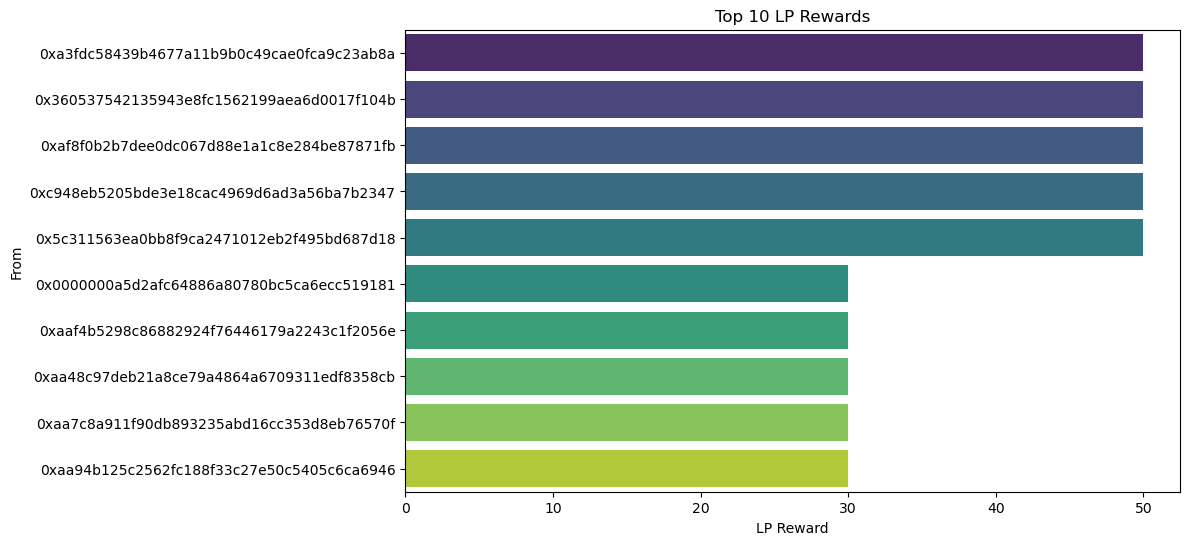

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sort the DataFrame by LP Reward in descending order
top_lp_rewards = results_df.sort_values('LP Reward', ascending=False)

# Select the top 10 addresses with the highest LP rewards
top_10_lp_rewards = top_lp_rewards.head(10)

# Plot the top 10 LP rewards and scores
plt.figure(figsize=(10, 6))
sns.barplot(x='LP Reward', y='From', data=top_10_lp_rewards, palette='viridis')
plt.xlabel('LP Reward')
plt.ylabel('From')
plt.title('Top 10 LP Rewards')
plt.show()


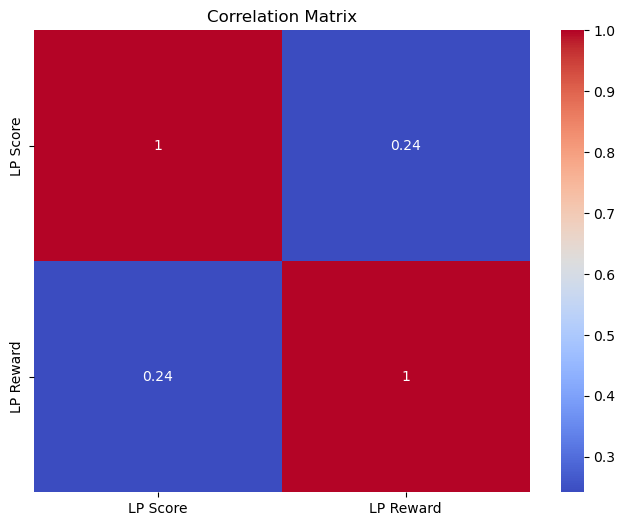

In [48]:
import seaborn as sns

# Calculate the correlation matrix
correlation_matrix = results_df[['LP Score', 'LP Reward']].corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [49]:
import pandas as pd

# Load the LP data from a CSV file
lp_data = pd.read_csv('./aave_barrow_contract.csv')

# Convert 'DateTime' column to datetime type
lp_data['DateTime'] = pd.to_datetime(lp_data['DateTime'])

# Define the scoring criteria and intervals
deposit_value_intervals = [0, 1, 10, 100, 1000, 10000, float('inf')]
deposit_value_scores = [10, 25, 40, 55, 70, 100]

deposit_time_intervals = [0, 30, 90, 180, 365, float('inf')]
deposit_time_scores = [10, 30, 50, 70, 100]

borrow_value_intervals = [0, 1, 10, 100, 1000, 10000, float('inf')]
borrow_value_scores = [10, 25, 40, 55, 70, 100]

borrow_time_intervals = [0, 30, 90, 180, 365, float('inf')]
borrow_time_scores = [10, 30, 50, 70, 100]

repayment_value_intervals = [0, 1, 10, 100, 1000, 10000, float('inf')]
repayment_value_scores = [10, 25, 40, 55, 70, 100]

# Create empty lists to store the addresses and values for each category
borrow_data = []
deposit_data = []
repayment_data = []

# Iterate over the rows in the LP data
for index, row in lp_data.iterrows():
    method = row['Method']
    from_address = row['From']
    value_out_eth = row['Value_OUT(ETH)']
    value_in_eth = row['Value_IN(ETH)']
    datetime = row['DateTime']

    if method == 'Borrow ETH':
        # Calculate the score for borrow value and time
        borrow_value_score = next(score for interval, score in zip(borrow_value_intervals, borrow_value_scores) if value_out_eth <= interval)
        borrow_time_score = next((score for interval, score in zip(borrow_time_intervals, borrow_time_scores) if (pd.Timestamp.now() - datetime).days <= interval), borrow_time_scores[-1])

        # Check if the address falls into the borrow category
        if borrow_value_score >= 10 or borrow_time_score >= 10:
            borrow_data.append([from_address, value_out_eth])

    elif method == 'Deposit ETH':
        # Calculate the score for deposit value and time
        deposit_value_score = next(score for interval, score in zip(deposit_value_intervals, deposit_value_scores) if value_in_eth <= interval)
        deposit_time_score = next((score for interval, score in zip(deposit_time_intervals, deposit_time_scores) if (pd.Timestamp.now() - datetime).days <= interval), deposit_time_scores[-1])

        # Check if the address falls into the deposit category
        if deposit_value_score >= 10 or deposit_time_score >= 10:
            deposit_data.append([from_address, value_in_eth])

    elif method == 'Repay ETH':
        # Calculate the score for repayment value
        repayment_value_score = next(score for interval, score in zip(repayment_value_intervals, repayment_value_scores) if value_in_eth <= interval)

        # Check if the address falls into the repayment category
        if repayment_value_score >= 10:
            repayment_data.append([from_address, value_in_eth])

# Create DataFrames for each category
borrow_df = pd.DataFrame(borrow_data, columns=['Borrow Address', 'Value_OUT(ETH)'])
deposit_df = pd.DataFrame(deposit_data, columns=['Deposit Address', 'Value_IN(ETH)'])
repayment_df = pd.DataFrame(repayment_data, columns=['Repayment Address', 'Value_IN(ETH)'])

# Print the tables
print("Borrow Addresses:")
print(borrow_df.to_string(index=False))

print("\nDeposit Addresses:")
print(deposit_df.to_string(index=False))

print("\nRepayment Addresses:")
print(repayment_df.to_string(index=False))


Borrow Addresses:
                            Borrow Address  Value_OUT(ETH)
0xba5e2a0a6e1426d3ed5b5dd182edc746f72b255f               0
0x9e5a57470a2a136a3d4de39e1996e05944c4b1fb               0
0x7d8d83200a76008702c9cd4a018e12a3636b66af               0
0x55769d0411006bd2e5ec13b0fa4b25abbff1cf79               0
0x55769d0411006bd2e5ec13b0fa4b25abbff1cf79               0
0x55769d0411006bd2e5ec13b0fa4b25abbff1cf79               0
0x9e5a57470a2a136a3d4de39e1996e05944c4b1fb               0
0xbdd96f13088edae6fb436c0f49fcda879ebd0eb7               0
0xe1d9db92c663118554c72f4cfaed4224a0670006               0
0x45f3fc38441b1aa7b60f8aad8954582b17c9503c               0
0x851ef0a28922435675c77d505601e625f65ff088               0
0xc34e6e034a7ae881fdfaa0ff977b5eb3eb769245               0
0x6e2e4991ebc00841e10419065c966b613bc4a84b               0
0x38c5e0f95b08b663602ec23223e7c0695d30410e               0
0x846a0f39ad86480014607598bfafcf89ff090bb3               0
0xd4ee113548dd66913dff6743e9b89e9fca7e

In [50]:

import pandas as pd

# Load the LP data from a CSV file
lp_data = pd.read_csv('./aave_barrow_contract.csv')

# Convert 'DateTime' column to datetime type
lp_data['DateTime'] = pd.to_datetime(lp_data['DateTime'])

# Define the scoring criteria and intervals
deposit_value_intervals = [0, 1, 10, 100, 1000, 10000, float('inf')]
deposit_value_scores = [10, 25, 40, 55, 70, 100]

deposit_time_intervals = [0, 30, 90, 180, 365, float('inf')]
deposit_time_scores = [10, 30, 50, 70, 100]

borrow_value_intervals = [0, 1, 10, 100, 1000, 10000, float('inf')]
borrow_value_scores = [10, 25, 40, 55, 70, 100]

borrow_time_intervals = [0, 30, 90, 180, 365, float('inf')]
borrow_time_scores = [10, 30, 50, 70, 100]

repayment_value_intervals = [0, 1, 10, 100, 1000, 10000, float('inf')]
repayment_value_scores = [10, 25, 40, 55, 70, 100]

# Define the LP reward matrix
min_reward = 50
max_reward = 500
reward_percentage = 0.66

# Create empty lists to store the LP scores and rewards for each address
address_scores = []
address_rewards = []

# Iterate over the rows in the LP data
for index, row in lp_data.iterrows():
    method = row['Method']
    from_address = row['From']
    value_out_eth = row['Value_OUT(ETH)']
    value_in_eth = row['Value_IN(ETH)']
    datetime = row['DateTime']

    if method == 'Borrow ETH':
        # Calculate the score for borrow value and time
        borrow_value_score = next(score for interval, score in zip(borrow_value_intervals, borrow_value_scores) if value_out_eth <= interval)
        borrow_time_score = next((score for interval, score in zip(borrow_time_intervals, borrow_time_scores) if (pd.Timestamp.now() - datetime).days <= interval), borrow_time_scores[-1])

        # Calculate the LP reward for borrow
        lp_reward = min_reward + ((borrow_value_score + borrow_time_score) / 2) * (max_reward - min_reward) / 100

    elif method == 'Deposit ETH':
        # Calculate the score for deposit value and time
        deposit_value_score = next(score for interval, score in zip(deposit_value_intervals, deposit_value_scores) if value_in_eth <= interval)
        deposit_time_score = next((score for interval, score in zip(deposit_time_intervals, deposit_time_scores) if (pd.Timestamp.now() - datetime).days <= interval), deposit_time_scores[-1])

        # Calculate the LP reward for deposit
        lp_reward = min_reward + ((deposit_value_score + deposit_time_score) / 2) * (max_reward - min_reward) / 100

    elif method == 'Repay ETH':
        # Calculate the score for repayment value
        repayment_value_score = next(score for interval, score in zip(repayment_value_intervals, repayment_value_scores) if value_in_eth <= interval)

        # Calculate the LP reward for repayment
        lp_reward = min_reward + (repayment_value_score * (max_reward - min_reward) / 100)

    # Add the address, LP score, and LP reward to the respective lists
    address_scores.append([from_address, lp_score])
    address_rewards.append([from_address, lp_reward])

# Create a dataframe for the LP scores
score_df = pd.DataFrame(address_scores, columns=['Address', 'LP Score'])

# Create a dataframe for the LP rewards
reward_df = pd.DataFrame(address_rewards, columns=['Address', 'LP Reward'])

# Print the LP scores dataframe
print("LP Scores:")
print(score_df.to_string(index=False))

print("\n")

# Print the LP rewards dataframe
print("LP Rewards:")
print(reward_df.to_string(index=False))


LP Scores:
                                   Address  LP Score
0x4365f8e70cf38c6ca67de41448508f2da8825500      41.5
0xd53c79ff8c473bbfe4e40e5525d4d24fd4b8534c      41.5
0xd53c79ff8c473bbfe4e40e5525d4d24fd4b8534c      41.5
0xeb52371f5a251e93799a64844a88d3f56872ad00      41.5
0xac4bd05953587836dfb12843a9951570ff403c0f      41.5
0xc9e4eb3a1777146ea9b8249903a47cdf2529da1e      41.5
0xac4bd05953587836dfb12843a9951570ff403c0f      41.5
0x6e2e4991ebc00841e10419065c966b613bc4a84b      41.5
0x9e5a57470a2a136a3d4de39e1996e05944c4b1fb      41.5
0x9e5a57470a2a136a3d4de39e1996e05944c4b1fb      41.5
0x3bb5284c01fc08d315499e5b506bf785df60f8a8      41.5
0x7e55b88309ac120a0ba8934f8e2faab8565b59be      41.5
0x3bb5284c01fc08d315499e5b506bf785df60f8a8      41.5
0x958914bc3fc61629dcc5c11ce9d2e1dc254f3e57      41.5
0x9e5a57470a2a136a3d4de39e1996e05944c4b1fb      41.5
0x5fe010dd84be57bb7bf0d29ab2eb24527a510ab5      41.5
0xba5e2a0a6e1426d3ed5b5dd182edc746f72b255f      41.5
0xc9e4eb3a1777146ea9b8249903a47cdf2

In [51]:
import pandas as pd

# Load the LP data from a CSV file
lp_data = pd.read_csv('./aave_barrow_contract.csv')

# Convert 'DateTime' column to datetime type
lp_data['DateTime'] = pd.to_datetime(lp_data['DateTime'])

# Define the scoring criteria and intervals
deposit_value_intervals = [0, 1, 10, 100, 1000, 10000, float('inf')]
deposit_value_scores = [10, 25, 40, 55, 70, 100]

deposit_time_intervals = [0, 30, 90, 180, 365, float('inf')]
deposit_time_scores = [10, 30, 50, 70, 100]

borrow_value_intervals = [0, 1, 10, 100, 1000, 10000, float('inf')]
borrow_value_scores = [10, 25, 40, 55, 70, 100]

borrow_time_intervals = [0, 30, 90, 180, 365, float('inf')]
borrow_time_scores = [10, 30, 50, 70, 100]

repayment_value_intervals = [0, 1, 10, 100, 1000, 10000, float('inf')]
repayment_value_scores = [10, 25, 40, 55, 70, 100]

# Define the LP reward matrix
min_reward = 50
max_reward = 500
reward_percentage = 0.66

# Create empty lists to store the addresses and values for each category
borrow_data = []
deposit_data = []
repayment_data = []
address_scores = []
address_rewards = []

# Iterate over the rows in the LP data
for index, row in lp_data.iterrows():
    method = row['Method']
    from_address = row['From']
    value_out_eth = row['Value_OUT(ETH)']
    value_in_eth = row['Value_IN(ETH)']
    datetime = row['DateTime']

    if method == 'Borrow ETH':
        # Calculate the score for borrow value and time
        borrow_value_score = next((score for interval, score in zip(borrow_value_intervals, borrow_value_scores) if value_out_eth <= interval), 10)
        borrow_time_score = next((score for interval, score in zip(borrow_time_intervals, borrow_time_scores) if (pd.Timestamp.now() - datetime).days <= interval), 10)

        # Calculate the LP reward for borrow
        lp_reward = min_reward + (borrow_value_score * 0.5 + borrow_time_score * 0.5) * (max_reward - min_reward) / 100
        lp_reward = min(max_reward, lp_reward)  # Ensure LP reward does not exceed the maximum reward

        # Add the address and value to the borrow data
        borrow_data.append([from_address, value_out_eth])

    elif method == 'Deposit ETH':
        # Calculate the score for deposit value and time
        deposit_value_score = next((score for interval, score in zip(deposit_value_intervals, deposit_value_scores) if value_in_eth <= interval), 10)
        deposit_time_score = next((score for interval, score in zip(deposit_time_intervals, deposit_time_scores) if (pd.Timestamp.now() - datetime).days <= interval), 10)

        # Calculate the LP reward for deposit
        lp_reward = min_reward + (deposit_value_score * 0.5 + deposit_time_score * 0.5) * (max_reward - min_reward) / 100
        lp_reward = min(max_reward, lp_reward)  # Ensure LP reward does not exceed the maximum reward

        # Add the address and value to the deposit data
        deposit_data.append([from_address, value_in_eth])

    elif method == 'Repay ETH':
        # Calculate the score for repayment value
        repayment_value_score = next((score for interval, score in zip(repayment_value_intervals, repayment_value_scores) if value_in_eth <= interval), 10)

        # Calculate the LP reward for repayment
        lp_reward = min_reward + (repayment_value_score * (max_reward - min_reward) / 100)
        lp_reward = min(max_reward, lp_reward)  # Ensure LP reward does not exceed the maximum reward

        # Add the address and value to the repayment data
        repayment_data.append([from_address, value_in_eth])

    # Add the address, LP score, and LP reward to the respective lists
    address_scores.append([from_address, lp_score])
    address_rewards.append([from_address, lp_reward])

# Create dataframes for each category
borrow_df = pd.DataFrame(borrow_data, columns=['Borrow Address', 'Value_OUT(ETH)'])
deposit_df = pd.DataFrame(deposit_data, columns=['Deposit Address', 'Value_IN(ETH)'])
repayment_df = pd.DataFrame(repayment_data, columns=['Repayment Address', 'Value_IN(ETH)'])

# Create a dataframe for the LP scores and rewards
lp_scores_df = pd.DataFrame(address_scores, columns=['Address', 'LP Score'])
lp_rewards_df = pd.DataFrame(address_rewards, columns=['Address', 'LP Reward'])

# Print the Borrow Addresses dataframe
print("Borrow Addresses:")
print(borrow_df)

print("\n")

# Print the Deposit Addresses dataframe
print("Deposit Addresses:")
print(deposit_df)

print("\n")

# Print the Repayment Addresses dataframe
print("Repayment Addresses:")
print(repayment_df)

print("\n")

# Print the LP Scores and Rewards dataframe
lp_scores_rewards_df = pd.merge(lp_scores_df, lp_rewards_df, on='Address')
print("LP Scores and Rewards:")
print(lp_scores_rewards_df)


Borrow Addresses:
                                 Borrow Address  Value_OUT(ETH)
0    0xba5e2a0a6e1426d3ed5b5dd182edc746f72b255f               0
1    0x9e5a57470a2a136a3d4de39e1996e05944c4b1fb               0
2    0x7d8d83200a76008702c9cd4a018e12a3636b66af               0
3    0x55769d0411006bd2e5ec13b0fa4b25abbff1cf79               0
4    0x55769d0411006bd2e5ec13b0fa4b25abbff1cf79               0
..                                          ...             ...
357  0x0907271304a2b6ae8feeb6103dd460c1cbcd6bca               0
358  0xabe2b5ec3b1104bf3628c3f9083fa1eb76b0eed4               0
359  0x5ceec11d2b03ef48fcea811db735912c5ef171e8               0
360  0xf9aa490e4581a4029762a170e9b16959f846afcf               0
361  0x2fc18c0ebb3a59a46ca91e1b1b42217cbcc30073               0

[362 rows x 2 columns]


Deposit Addresses:
                                 Deposit Address  Value_IN(ETH)
0     0xac4bd05953587836dfb12843a9951570ff403c0f      15.768176
1     0x6e2e4991ebc00841e10419065c966b613

In [52]:
import pandas as pd

# Read the dataset into a pandas DataFrame
df = pd.read_csv("./aave_barrow_contract.csv")

# Define the scoring criteria and intervals
borrow_value_intervals = [0, 1, 10, 100, 1000, 10000]
borrow_value_scores = [10, 25, 40, 55, 70, 100]

borrow_time_intervals = [0, 30, 90, 180, 365]
borrow_time_scores = [10, 30, 50, 70, 100]

repayment_value_intervals = [0, 1, 10, 100, 1000, 10000]
repayment_value_scores = [10, 25, 40, 55, 70, 100]

deposit_value_intervals = [0, 1, 10, 100, 1000, 10000]
deposit_value_scores = [10, 25, 40, 55, 70, 100]

deposit_time_intervals = [0, 30, 90, 180, 365]
deposit_time_scores = [10, 30, 50, 70, 100]

# Group the DataFrame by the 'From' column (addresses)
grouped_lp_data = df.groupby('From')

# Create an empty dictionary to store the LP scores for each address
lp_scores = {}

# Iterate over each unique address in the dataset
for address, group_data in grouped_lp_data:
    method = group_data['Method'].unique()[0]
    
    if 'Borrow ETH' in method:
        value_out_eth = group_data['Value_OUT(ETH)'].sum()
        borrow_value_score = None
        borrow_time_score = None
        
        # Calculate the score for borrow value
        for interval, score in zip(borrow_value_intervals, borrow_value_scores):
            if value_out_eth <= interval:
                borrow_value_score = score
                break
        
        # Calculate the score for borrow time
        for interval, score in zip(borrow_time_intervals, borrow_time_scores):
            days_since_borrow = (pd.Timestamp.now() - pd.to_datetime(group_data['DateTime'])).days
            if days_since_borrow <= interval:
                borrow_time_score = score
                break
        
        if borrow_value_score is not None and borrow_time_score is not None:
            lp_score = borrow_value_score + borrow_time_score
            if address in lp_scores:
                lp_scores[address] += lp_score
            else:
                lp_scores[address] = lp_score
        
    elif 'Deposit ETH' in method:
        value_in_eth = group_data['Value_IN(ETH)'].sum()
        deposit_value_score = None
        deposit_time_score = None
        
        # Calculate the score for deposit value
        for interval, score in zip(deposit_value_intervals, deposit_value_scores):
            if value_in_eth <= interval:
                deposit_value_score = score
                break
        
        # Calculate the score for deposit time
        for interval, score in zip(deposit_time_intervals, deposit_time_scores):
            days_since_deposit = (pd.Timestamp.now() - pd.to_datetime(group_data['DateTime'])).days
            if days_since_deposit <= interval:
                deposit_time_score = score
                break
        
        if deposit_value_score is not None and deposit_time_score is not None:
            lp_score = deposit_value_score + deposit_time_score
            if address in lp_scores:
                lp_scores[address] += lp_score
            else:
                lp_scores[address] = lp_score
        
    elif 'Repay ETH' in method:
        value_in_eth = group_data['Value_IN(ETH)'].sum()
        repayment_value_score = None
        
        # Calculate the score for repayment value
        for interval, score in zip(repayment_value_intervals, repayment_value_scores):
            if value_in_eth <= interval:
                repayment_value_score = score
                break
        
        if repayment_value_score is not None:
            lp_score = -repayment_value_score  # Negative score for repayment addresses
            if address in lp_scores:
                lp_scores[address] += lp_score
            else:
                lp_scores[address] = lp_score

# Calculate the sum of scores for each address
lp_scores_sum = {address: sum(scores) for address, scores in lp_scores.items()}

# Calculate the LP reward for each address based on the sum of scores
max_score = 500  # Maximum LP score
lp_rewards = {address: (score_sum / max_score) * 100 for address, score_sum in lp_scores_sum.items()}

# Create a DataFrame for the LP rewards
lp_rewards_df = pd.DataFrame(list(lp_rewards.items()), columns=['Address', 'LP Score'])
lp_rewards_df['LP Reward'] = (lp_rewards_df['LP Score'] / max_score) * 100

# Print the LP rewards DataFrame
print("LP Rewards:")
print(lp_rewards_df)

AttributeError: 'Series' object has no attribute 'days'

In [ ]:
import pandas as pd

# Read the dataset into a pandas DataFrame
df = pd.read_csv("./aave_barrow_contract.csv")

# Define the scoring criteria and intervals
borrow_value_intervals = [0, 1, 10, 100, 1000, 10000]
borrow_value_scores = [10, 25, 40, 55, 70, 100]

borrow_time_intervals = [0, 30, 90, 180, 365]
borrow_time_scores = [10, 30, 50, 70, 100]

repayment_value_intervals = [0, 1, 10, 100, 1000, 10000]
repayment_value_scores = [10, 25, 40, 55, 70, 100]

deposit_value_intervals = [0, 1, 10, 100, 1000, 10000]
deposit_value_scores = [10, 25, 40, 55, 70, 100]

deposit_time_intervals = [0, 30, 90, 180, 365]
deposit_time_scores = [10, 30, 50, 70, 100]

# Group the DataFrame by the 'From' column (addresses)
grouped_lp_data = df.groupby('From')

# Create an empty dictionary to store the LP scores for each address
lp_scores = {}

# Iterate over each unique address in the dataset
for address, group_data in grouped_lp_data:
    method = group_data['Method'].unique()[0]
    
    if 'Borrow ETH' in method:
        value_out_eth = group_data['Value_OUT(ETH)'].sum()
        borrow_value_score = None
        borrow_time_score = None
        
        # Calculate the score for borrow value
        for interval, score in zip(borrow_value_intervals, borrow_value_scores):
            if value_out_eth <= interval:
                borrow_value_score = score
                break
        
        # Calculate the score for borrow time
        for interval, score in zip(borrow_time_intervals, borrow_time_scores):
            days_since_borrow = (pd.Timestamp.now() - pd.to_datetime(group_data['DateTime'])).days
            if days_since_borrow <= interval:
                borrow_time_score = score
                break
        
        if borrow_value_score is not None and borrow_time_score is not None:
            lp_score = borrow_value_score + borrow_time_score
            if address in lp_scores:
                lp_scores[address] += lp_score
            else:
                lp_scores[address] = lp_score
        
    elif 'Deposit ETH' in method:
        value_in_eth = group_data['Value_IN(ETH)'].sum()
        deposit_value_score = None
        deposit_time_score = None
        
        # Calculate the score for deposit value
        for interval, score in zip(deposit_value_intervals, deposit_value_scores):
            if value_in_eth <= interval:
                deposit_value_score = score
                break
        
        # Calculate the score for deposit time
        for interval, score in zip(deposit_time_intervals, deposit_time_scores):
            days_since_deposit = (pd.Timestamp.now() - pd.to_datetime(group_data['DateTime'])).days
            if days_since_deposit <= interval:
                deposit_time_score = score
                break
        
        if deposit_value_score is not None and deposit_time_score is not None:
            lp_score = deposit_value_score + deposit_time_score
            if address in lp_scores:
                lp_scores[address] += lp_score
            else:
                lp_scores[address] = lp_score
        
    elif 'Repay ETH' in method:
        value_in_eth = group_data['Value_IN(ETH)'].sum()
        repayment_value_score = None
        
        # Calculate the score for repayment value
        for interval, score in zip(repayment_value_intervals, repayment_value_scores):
            if value_in_eth <= interval:
                repayment_value_score = score
                break
        
        if repayment_value_score is not None:
            lp_score = -repayment_value_score  # Negative score for repayment addresses
            if address in lp_scores:
                lp_scores[address] += lp_score
            else:
                lp_scores[address] = lp_score

# Calculate the maximum LP score
max_score = max(lp_scores.values())

# Calculate the LP reward for each address
lp_rewards = {address: (score / max_score) * 100 for address, score in lp_scores.items()}

# Create a dataframe for unique addresses, LP scores, and LP rewards
lp_scores_rewards_df = pd.DataFrame({'Address': lp_scores.keys(), 'LP Score': lp_scores.values(), 'LP Reward': lp_rewards.values()})

# Display the dataframe
print("LP Scores and Rewards:")
print(lp_scores_rewards_df)


AttributeError: 'Series' object has no attribute 'days'

In [ ]:
import pandas as pd

# Read the dataset into a pandas DataFrame
df = pd.read_csv("./aave_barrow_contract.csv")

# Define the scoring criteria and intervals
borrow_value_intervals = [0, 1, 10, 100, 1000, 10000]
borrow_value_scores = [10, 25, 40, 55, 70, 100]

borrow_time_intervals = [0, 30, 90, 180, 365]
borrow_time_scores = [10, 30, 50, 70, 100]

repayment_value_intervals = [0, 1, 10, 100, 1000, 10000]
repayment_value_scores = [10, 25, 40, 55, 70, 100]

deposit_value_intervals = [0, 1, 10, 100, 1000, 10000]
deposit_value_scores = [10, 25, 40, 55, 70, 100]

deposit_time_intervals = [0, 30, 90, 180, 365]
deposit_time_scores = [10, 30, 50, 70, 100]

# Group the DataFrame by the 'From' column (addresses)
grouped_lp_data = df.groupby('From')

# Create an empty dictionary to store the LP scores for each address
lp_scores = {}

# Iterate over each unique address in the dataset
for address, group_data in grouped_lp_data:
    method = group_data['Method'].unique()[0]
    
    if 'Borrow ETH' in method:
        value_out_eth = group_data['Value_OUT(ETH)'].sum()
        borrow_value_score = None
        borrow_time_score = None
        
        # Calculate the score for borrow value
        for interval, score in zip(borrow_value_intervals, borrow_value_scores):
            if value_out_eth <= interval:
                borrow_value_score = score
                break
        
        # Calculate the score for borrow time
        for interval, score in zip(borrow_time_intervals, borrow_time_scores):
            days_since_borrow = (pd.Timestamp.now() - pd.to_datetime(group_data['DateTime'].iloc[0])).days
            if days_since_borrow <= interval:
                borrow_time_score = score
                break
        
        if borrow_value_score is not None and borrow_time_score is not None:
            lp_score = borrow_value_score + borrow_time_score
            if address in lp_scores:
                lp_scores[address] += lp_score
            else:
                lp_scores[address] = lp_score
        
    elif 'Deposit ETH' in method:
        value_in_eth = group_data['Value_IN(ETH)'].sum()
        deposit_value_score = None
        deposit_time_score = None
        
        # Calculate the score for deposit value
        for interval, score in zip(deposit_value_intervals, deposit_value_scores):
            if value_in_eth <= interval:
                deposit_value_score = score
                break
        
        # Calculate the score for deposit time
        for interval, score in zip(deposit_time_intervals, deposit_time_scores):
            days_since_deposit = (pd.Timestamp.now() - pd.to_datetime(group_data['DateTime'].iloc[0])).days
            if days_since_deposit <= interval:
                deposit_time_score = score
                break
        
        if deposit_value_score is not None and deposit_time_score is not None:
            lp_score = deposit_value_score + deposit_time_score
            if address in lp_scores:
                lp_scores[address] += lp_score
            else:
                lp_scores[address] = lp_score
        
    elif 'Repay ETH' in method:
        value_in_eth = group_data['Value_IN(ETH)'].sum()
        repayment_value_score = None
        
        # Calculate the score for repayment value
        for interval, score in zip(repayment_value_intervals, repayment_value_scores):
            if value_in_eth <= interval:
                repayment_value_score = score
                break
        
        if repayment_value_score is not None:
            lp_score = repayment_value_score  # No negative score for repayment addresses
            if address in lp_scores:
                lp_scores[address] += lp_score
            else:
                lp_scores[address] = lp_score

# Calculate the maximum LP score
max_score = 500

# Calculate the LP reward for each address
lp_rewards = {address: (lp_score / max_score) * 100 for address, lp_score in lp_scores.items()}

# Create a dataframe for unique addresses, LP scores, and LP rewards
lp_scores_rewards_df = pd.DataFrame({'Address': lp_scores.keys(), 'LP Score': lp_scores.values(), 'LP Reward': lp_rewards.values()})

# Display the dataframe
print("LP Scores and Rewards:")
print(lp_scores_rewards_df)


LP Scores and Rewards:
                                         Address  LP Score  LP Reward
0     0x0000000a5d2afc64886a80780bc5ca6ecc519181       125       25.0
1     0x0000000f3a9e446d0a6f976df5f0ed1b324dcd0e       125       25.0
2     0x00002b503a75998c97508916a74fdb41934fa030       155       31.0
3     0x0000ce08fa224696a819877070bf378e8b131acf       125       25.0
4     0x0025500c6a6bcaebde159db6a307f4d38503a079       110       22.0
...                                          ...       ...        ...
1620  0xffb3468b6861ba7044fcf61a2d976028204efc49        40        8.0
1621  0xffc57ab280cb8d1e47e11ce225f113612cff3d8e        25        5.0
1622  0xfff6b41a29881fc97bd6e8778529b1e37597d94a       125       25.0
1623  0xfffa68b3c30f860afcbfe52583ed6b5c0846de52       125       25.0
1624  0xfffb40347816873ca038756cc87bc610144166b2       125       25.0

[1625 rows x 3 columns]


In [ ]:

lp_scores_rewards_df.sort_values(by='LP Score', ascending= False)

,Address,LP Score,LP Reward
1096,0xaf8f0b2b7dee0dc067d88e1a1c8e284be87871fb,200,40.0
232,0x2050e02fc525d2ecd8a5139953987505f56ffc1e,170,34.0
789,0x7b23e38fbd0e677a1d1f72fe29a1aea9fd83ade8,170,34.0
472,0x4786c6690904cbee4a6c2b5673bfa90be8abadab,170,34.0
464,0x45a510e88daf77a29ceae0ee7cacbc5db8d2ebda,170,34.0
...,...,...,...
551,0x54891239fecf661683e7430068c0729240f773d2,25,5.0
1119,0xb43f8f3c1b2e4ccfd9535a0501dd857bac7b7c21,25,5.0
500,0x4bb12cc382e36b4b6faf7bdca7708969aed258ef,25,5.0
498,0x4b84c7ddc8c295fb3d2bfde393b17d1c2e2bd17d,25,5.0


In [ ]:
import pandas as pd

# Read the dataset into a pandas DataFrame
df = pd.read_csv("./aave_barrow_contract.csv")

# Define the scoring criteria and intervals
borrow_value_intervals = [0, 1, 10, 100, 1000, 10000]
borrow_value_scores = [10, 25, 40, 55, 70, 100]

borrow_time_intervals = [0, 30, 90, 180, 365]
borrow_time_scores = [10, 30, 50, 70, 100]

repayment_value_intervals = [0, 1, 10, 100, 1000, 10000]
repayment_value_scores = [10, 25, 40, 55, 70, 100]

deposit_value_intervals = [0, 1, 10, 100, 1000, 10000]
deposit_value_scores = [10, 25, 40, 55, 70, 100]

deposit_time_intervals = [0, 30, 90, 180, 365]
deposit_time_scores = [10, 30, 50, 70, 100]

# Group the DataFrame by the 'From' column (addresses)
grouped_lp_data = df.groupby('From')

# Create empty dataframes for Borrow, Deposit, and Repayment addresses
borrow_df = pd.DataFrame(columns=['Address', 'Value_OUT(ETH)'])
deposit_df = pd.DataFrame(columns=['Address', 'Value_IN(ETH)'])
repayment_df = pd.DataFrame(columns=['Address', 'Value_IN(ETH)'])

# Iterate over each unique address in the dataset
for address, group_data in grouped_lp_data:
    method = group_data['Method'].unique()[0]
    
    if 'Borrow ETH' in method:
        value_out_eth = group_data['Value_OUT(ETH)'].sum()
        borrow_df = pd.concat([borrow_df, pd.DataFrame({'Address': [address], 'Value_OUT(ETH)': [value_out_eth]})], ignore_index=True)
        
    elif 'Deposit ETH' in method:
        value_in_eth = group_data['Value_IN(ETH)'].sum()
        deposit_df = pd.concat([deposit_df, pd.DataFrame({'Address': [address], 'Value_IN(ETH)': [value_in_eth]})], ignore_index=True)
        
    elif 'Repay ETH' in method:
        value_in_eth = group_data['Value_IN(ETH)'].sum()
        repayment_df = pd.concat([repayment_df, pd.DataFrame({'Address': [address], 'Value_IN(ETH)': [value_in_eth]})], ignore_index=True)

# Display the Borrow Addresses dataframe
print("Borrow Addresses:")
print(borrow_df)

# Display the Deposit Addresses dataframe
print("Deposit Addresses:")
print(deposit_df)

# Display the Repayment Addresses dataframe
print("Repayment Addresses:")
print(repayment_df)


Borrow Addresses:
                                       Address Value_OUT(ETH)
0   0x0025500c6a6bcaebde159db6a307f4d38503a079              0
1   0x032e9ea7e5ca19937c06cfa101b5bb1b55150910              0
2   0x0351b0b81fdd1db5dad0617d97c598cd3c37baaf              0
3   0x04f2c60d181d3255968a86a0fc76c524265e200c              0
4   0x06cacac9b62daad2cc8869b96ab6c61f7d489d68              0
..                                         ...            ...
89  0xf07a21ad94bc379684ed1d4fee1a8371e4406298              0
90  0xf9aa490e4581a4029762a170e9b16959f846afcf              0
91  0xfde76d38dbbea54251ea4107ea547a75a0b98f3d              0
92  0xfefcf7f02b2098829c83d5b99bbb2be464fecb86              0
93  0xff643a1ab6818f11589a56dddfd18605f30ef1ce              0

[94 rows x 2 columns]
Deposit Addresses:
                                         Address  Value_IN(ETH)
0     0x0000000a5d2afc64886a80780bc5ca6ecc519181   5.000000e-06
1     0x0000000f3a9e446d0a6f976df5f0ed1b324dcd0e   5.000000e-06
2   

In [ ]:
data[data['Method'] == "Borrow ETH"].sort_values(by='Value_OUT(ETH)', ascending=False)

,Txhash,Blockno,UnixTimestamp,DateTime,From,To,ContractAddress,Value_IN(ETH),Value_OUT(ETH),CurrentValue @ $1869.43/Eth,TxnFee(ETH),TxnFee(USD),Historical $Price/Eth,Method
16,0x2acb286572e57fc3593829d479371b4ac633d8189240...,22173871,1662487201,06/09/2022 18:00,0xba5e2a0a6e1426d3ed5b5dd182edc746f72b255f,0x76d3030728e52deb8848d5613abade88441cbc59,NaN,0.0,0,0.0,0.000155,0.289728,1558.90,Borrow ETH
3893,0x59040014443f39e4db7196e87c7370856182408d6556...,23381422,1663305627,16/09/2022 05:20,0xeb18c039ce0be7b26f872d9847bf94a649aab797,0x76d3030728e52deb8848d5613abade88441cbc59,NaN,0.0,0,0.0,0.000021,0.039662,1433.97,Borrow ETH
3888,0x3fb7c00781fc89e5e791ccacd56f2fceff524a0bc742...,23379635,1663303720,16/09/2022 04:48,0xfee0a5607c453f0ea32599ad0388eabd37a9c404,0x76d3030728e52deb8848d5613abade88441cbc59,NaN,0.0,0,0.0,0.000024,0.044804,1433.97,Borrow ETH
3885,0xc1716ca032395ddedd48bb44464ccd5af41b22daa73a...,23379124,1663303177,16/09/2022 04:39,0x1049eb83482836c8fdef5d08bd0a908e87234fcf,0x76d3030728e52deb8848d5613abade88441cbc59,NaN,0.0,0,0.0,0.000021,0.039053,1433.97,Borrow ETH
3869,0xdfce9ba98d083ccf0fde1a7b5b9d1a0f322857be0b52...,23373346,1663298034,16/09/2022 03:13,0xbad9bc6b6d3f5629418f9a9e0342cd98233dc12f,0x76d3030728e52deb8848d5613abade88441cbc59,NaN,0.0,0,0.0,0.000031,0.058485,1433.97,Borrow ETH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2896,0xa21c4b859ddfbc2090552dee8dde19c8bb1d803c768c...,23042711,1663109968,13/09/2022 22:59,0x2151578e1fec29361bb0481312ea6b935014d636,0x76d3030728e52deb8848d5613abade88441cbc59,NaN,0.0,0,0.0,0.000048,0.089527,1574.56,Borrow ETH
2871,0x9582f9f74d5ca78c45cc5260d01edfb5c6c96afd4f9f...,23028370,1663099772,13/09/2022 20:09,0x90bb6df38b9bf66cfcb71f20dbb992de10e5b6ea,0x76d3030728e52deb8848d5613abade88441cbc59,NaN,0.0,0,0.0,0.000108,0.202806,1574.56,Borrow ETH
2868,0x43955e17babc89cf76d392c53e3f9630d6616eef3ab5...,23027153,1663098906,13/09/2022 19:55,0x90bb6df38b9bf66cfcb71f20dbb992de10e5b6ea,0x76d3030728e52deb8848d5613abade88441cbc59,NaN,0.0,0,0.0,0.000126,0.235292,1574.56,Borrow ETH
2864,0xf6b99d3863c03b3108690e77e233091b0f72748cce5d...,23026432,1663098486,13/09/2022 19:48,0x2151578e1fec29361bb0481312ea6b935014d636,0x76d3030728e52deb8848d5613abade88441cbc59,NaN,0.0,0,0.0,0.000102,0.189977,1574.56,Borrow ETH


In [ ]:
data.From.value_counts()

0x9ef1e5eea13131065d64e53a0595ea487746324a    128
0x88b0ea576428da635d0fa9deb686765c90cfde2e     79
0x63aef8da947ed56ed0b512267159a8964a87fa82     45
0x4d3869e2451d28bb4f03aeda60322eaf01e912db     37
0xed51d70c30acbab4ca261057c4dd94f8942127de     36
                                             ... 
0x966146db85c1dad7c8218a7f5b48c9e5d3ae0c20      1
0x7b7b2500f881c1fa03f083906f3d02e318032297      1
0xbf7697e1f7cb94fa50cbb461e86793877bd139ad      1
0xc0f872a7127bdc6d98af04899d1a1d22376c7b6b      1
0xa0d86993bf9593a9186c7f022e31bd0d32808bf1      1
Name: From, Length: 2476, dtype: int64

In [ ]:
import pandas as pd

# Read the dataset into a pandas DataFrame
df = pd.read_csv("./aave_barrow_contract.csv")

# Define the scoring criteria and intervals
borrow_value_intervals = [0, 1, 10, 100, 1000, 10000]
borrow_value_scores = [10, 25, 40, 55, 70, 100]

borrow_time_intervals = [0, 30, 90, 180, 365]
borrow_time_scores = [10, 30, 50, 70, 100]

repayment_value_intervals = [0, 1, 10, 100, 1000, 10000]
repayment_value_scores = [10, 25, 40, 55, 70, 100]

deposit_value_intervals = [0, 1, 10, 100, 1000, 10000]
deposit_value_scores = [10, 25, 40, 55, 70, 100]

deposit_time_intervals = [0, 30, 90, 180, 365]
deposit_time_scores = [10, 30, 50, 70, 100]

# Group the DataFrame by the 'From' column (addresses)
grouped_lp_data = df.groupby('From')

# Create empty dataframes for Borrow, Deposit, and Repayment addresses
borrow_df = pd.DataFrame(columns=['Address', 'DateTime', 'Value_OUT(ETH)', 'Borrow Score'])
deposit_df = pd.DataFrame(columns=['Address', 'DateTime', 'Value_IN(ETH)', 'Deposit Score'])
repayment_df = pd.DataFrame(columns=['Address', 'DateTime', 'Value_IN(ETH)', 'Repayment Score'])

# Iterate over each unique address in the dataset
for address, group_data in grouped_lp_data:
    method = group_data['Method'].unique()[0]
    
    if 'Borrow ETH' in method:
        value_out_eth = group_data['Value_OUT(ETH)'].sum()
        borrow_value_score = 0
        borrow_time_score = 0
        
        # Calculate the score for borrow value
        for interval, score in zip(borrow_value_intervals, borrow_value_scores):
            if value_out_eth <= interval:
                borrow_value_score = score
                break
        
        # Calculate the score for borrow time
        days_since_borrow = (pd.Timestamp.now() - pd.to_datetime(group_data['DateTime'])).dt.days
        days_since_borrow = days_since_borrow.min()
        for interval, score in zip(borrow_time_intervals, borrow_time_scores):
            if days_since_borrow <= interval:
                borrow_time_score = score
                break
        
        borrow_score = borrow_value_score + borrow_time_score
        borrow_df = pd.concat([borrow_df, pd.DataFrame({'Address': address, 'DateTime': group_data['DateTime'].iloc[0],
                                      'Value_OUT(ETH)': value_out_eth, 'Borrow Score': borrow_score}, index=[0])], ignore_index=True)
        
    elif 'Deposit ETH' in method:
        value_in_eth = group_data['Value_IN(ETH)'].sum()
        deposit_value_score = 0
        deposit_time_score = 0
        
        # Calculate the score for deposit value
        for interval, score in zip(deposit_value_intervals, deposit_value_scores):
            if value_in_eth <= interval:
                deposit_value_score = score
                break
        
        # Calculate the score for deposit time
        days_since_deposit = (pd.Timestamp.now() - pd.to_datetime(group_data['DateTime'])).dt.days
        days_since_deposit = days_since_deposit.min()
        for interval, score in zip(deposit_time_intervals, deposit_time_scores):
            if days_since_deposit <= interval:
                deposit_time_score = score
                break
        
        deposit_score = deposit_value_score + deposit_time_score
        deposit_df = pd.concat([deposit_df, pd.DataFrame({'Address': address, 'DateTime': group_data['DateTime'].iloc[0],
                                        'Value_IN(ETH)': value_in_eth, 'Deposit Score': deposit_score}, index=[0])], ignore_index=True)
        
    elif 'Repay ETH' in method:
        value_in_eth = group_data['Value_IN(ETH)'].sum()
        repayment_value_score = 0
        
        # Calculate the score for repayment value
        for interval, score in zip(repayment_value_intervals, repayment_value_scores):
            if value_in_eth <= interval:
                repayment_value_score = score
                break
        
        repayment_df = pd.concat([repayment_df, pd.DataFrame({'Address': address, 'DateTime': group_data['DateTime'].iloc[0],
                                            'Value_IN(ETH)': value_in_eth, 'Repayment Score': repayment_value_score}, index=[0])], ignore_index=True)

# Print the Borrow, Deposit, and Repayment dataframes
print("Borrow Addresses:")
print(borrow_df)
print("\nDeposit Addresses:")
print(deposit_df)
print("\nRepayment Addresses:")
print(repayment_df)


Borrow Addresses:
                                       Address          DateTime  \
0   0x0025500c6a6bcaebde159db6a307f4d38503a079  15/09/2022 02:04   
1   0x032e9ea7e5ca19937c06cfa101b5bb1b55150910  07/09/2022 10:59   
2   0x0351b0b81fdd1db5dad0617d97c598cd3c37baaf  08/09/2022 00:47   
3   0x04f2c60d181d3255968a86a0fc76c524265e200c  13/09/2022 02:04   
4   0x06cacac9b62daad2cc8869b96ab6c61f7d489d68  14/09/2022 15:32   
..                                         ...               ...   
89  0xf07a21ad94bc379684ed1d4fee1a8371e4406298  16/09/2022 21:41   
90  0xf9aa490e4581a4029762a170e9b16959f846afcf  17/09/2022 13:23   
91  0xfde76d38dbbea54251ea4107ea547a75a0b98f3d  14/09/2022 15:03   
92  0xfefcf7f02b2098829c83d5b99bbb2be464fecb86  14/09/2022 20:36   
93  0xff643a1ab6818f11589a56dddfd18605f30ef1ce  17/09/2022 08:39   

   Value_OUT(ETH) Borrow Score  
0               0          110  
1               0           10  
2               0          110  
3               0          110  


In [ ]:
data[data['From']== "0x050d68c8078e46ca57c9c2bff589be2db1440040"]

,Txhash,Blockno,UnixTimestamp,DateTime,From,To,ContractAddress,Value_IN(ETH),Value_OUT(ETH),CurrentValue @ $1869.43/Eth,TxnFee(ETH),TxnFee(USD),Historical $Price/Eth,Method
4435,0x34bf1728a7dd2f3a28d42e8190f5b8f1101cbbdee73d...,23539707,1663434681,17/09/2022 17:11,0x050d68c8078e46ca57c9c2bff589be2db1440040,0x76d3030728e52deb8848d5613abade88441cbc59,NaN,0.165,0,308.45595,0.000041,0.076363,1469.05,Repay ETH


In [ ]:
import pandas as pd

# Read the dataset into a pandas DataFrame
df = pd.read_csv("./aave_barrow_contract.csv")

# Define the scoring criteria and intervals
borrow_value_intervals = [0, 1, 10, 100, 1000, 10000]
borrow_value_scores = [10, 25, 40, 55, 70, 100]

borrow_time_intervals = [0, 30, 90, 180, 365]
borrow_time_scores = [10, 30, 50, 70, 100]

repayment_value_intervals = [0, 1, 10, 100, 1000, 10000]
repayment_value_scores = [10, 25, 40, 55, 70, 100]

deposit_value_intervals = [0, 1, 10, 100, 1000, 10000]
deposit_value_scores = [10, 25, 40, 55, 70, 100]

deposit_time_intervals = [0, 30, 90, 180, 365]
deposit_time_scores = [10, 30, 50, 70, 100]

# Group the DataFrame by the 'From' column (addresses)
grouped_lp_data = df.groupby('From')

# Create empty DataFrames for borrow, deposit, and repayment addresses
borrow_df = pd.DataFrame(columns=['Address', 'DateTime', 'Value_OUT(ETH)', 'Borrow Score'])
deposit_df = pd.DataFrame(columns=['Address', 'DateTime', 'Value_IN(ETH)', 'Deposit Score'])
repayment_df = pd.DataFrame(columns=['Address', 'DateTime', 'Value_IN(ETH)', 'Repayment Score'])

# Iterate over each unique address in the dataset
for address, group_data in grouped_lp_data:
    method = group_data['Method'].unique()[0]
    
    if 'Borrow ETH' in method:
        value_out_eth = group_data['Value_OUT(ETH)'].sum()
        borrow_value_score = None
        borrow_time_score = None
        
        # Calculate the score for borrow value
        for interval, score in zip(borrow_value_intervals, borrow_value_scores):
            if interval <= value_out_eth < interval + 1:
                borrow_value_score = score
                break
        
        # Calculate the score for borrow time
        days_since_borrow = (pd.Timestamp.now() - pd.to_datetime(group_data['DateTime'])).dt.days
        if (days_since_borrow <= 30).any():
            borrow_time_score = 10
        elif (days_since_borrow <= 90).any():
            borrow_time_score = 30
        elif (days_since_borrow <= 180).any():
            borrow_time_score = 50
        elif (days_since_borrow <= 365).any():
            borrow_time_score = 70
        else:
            borrow_time_score = 100
        
        if borrow_value_score is not None and borrow_time_score is not None:
            borrow_score = borrow_value_score + borrow_time_score
            borrow_df = borrow_df.append({'Address': address, 'DateTime': group_data['DateTime'].iloc[0],
                                          'Value_OUT(ETH)': value_out_eth, 'Borrow Score': borrow_score}, ignore_index=True)
        
    elif 'Deposit ETH' in method:
        value_in_eth = group_data['Value_IN(ETH)'].sum()
        deposit_value_score = None
        deposit_time_score = None
        
        # Calculate the score for deposit value
        for interval, score in zip(deposit_value_intervals, deposit_value_scores):
            if interval <= value_in_eth < interval + 1:
                deposit_value_score = score
                break
        
        # Calculate the score for deposit time
        days_since_deposit = (pd.Timestamp.now() - pd.to_datetime(group_data['DateTime'])).dt.days
        if (days_since_deposit <= 30).any():
            deposit_time_score = 10
        elif (days_since_deposit <= 90).any():
            deposit_time_score = 30
        elif (days_since_deposit <= 180).any():
            deposit_time_score = 50
        elif (days_since_deposit <= 365).any():
            deposit_time_score = 70
        else:
            deposit_time_score = 100
        
        if deposit_value_score is not None and deposit_time_score is not None:
            deposit_score = deposit_value_score + deposit_time_score
            deposit_df = deposit_df.append({'Address': address, 'DateTime': group_data['DateTime'].iloc[0],
                                            'Value_IN(ETH)': value_in_eth, 'Deposit Score': deposit_score}, ignore_index=True)
        
    elif 'Repay ETH' in method:
        value_in_eth = group_data['Value_IN(ETH)'].sum()
        repayment_value_score = None
        
        # Calculate the score for repayment value
        for interval, score in zip(repayment_value_intervals, repayment_value_scores):
            if interval <= value_in_eth < interval + 1:
                repayment_value_score = score
                break
        
        if repayment_value_score is not None:
            repayment_score = repayment_value_score
            repayment_df = repayment_df.append({'Address': address, 'DateTime': group_data['DateTime'].iloc[0],
                                                'Value_IN(ETH)': value_in_eth, 'Repayment Score': repayment_score}, ignore_index=True)

# Display the borrow addresses dataframe
print("Borrow Addresses:")
print(borrow_df)

# Display the deposit addresses dataframe
print("Deposit Addresses:")
print(deposit_df)

# Display the repayment addresses dataframe
print("Repayment Addresses:")
print(repayment_df)


/var/folders/yc/x90wh_kn09v92yybd6xj3p4h0000gn/T/ipykernel_47540/2416921610.py:89: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/yc/x90wh_kn09v92yybd6xj3p4h0000gn/T/ipykernel_47540/2416921610.py:89: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/yc/x90wh_kn09v92yybd6xj3p4h0000gn/T/ipykernel_47540/2416921610.py:89: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/yc/x90wh_kn09v92yybd6xj3p4h0000gn/T/ipykernel_47540/2416921610.py:60: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/yc/x90wh_kn09v92yybd6xj3p4h0000gn/T/ipykernel_47540/2416921610.py:89: FutureWarning:

The frame.append method is de

Borrow Addresses:
                                       Address          DateTime  \
0   0x0025500c6a6bcaebde159db6a307f4d38503a079  15/09/2022 02:04   
1   0x032e9ea7e5ca19937c06cfa101b5bb1b55150910  07/09/2022 10:59   
2   0x0351b0b81fdd1db5dad0617d97c598cd3c37baaf  08/09/2022 00:47   
3   0x04f2c60d181d3255968a86a0fc76c524265e200c  13/09/2022 02:04   
4   0x06cacac9b62daad2cc8869b96ab6c61f7d489d68  14/09/2022 15:32   
..                                         ...               ...   
89  0xf07a21ad94bc379684ed1d4fee1a8371e4406298  16/09/2022 21:41   
90  0xf9aa490e4581a4029762a170e9b16959f846afcf  17/09/2022 13:23   
91  0xfde76d38dbbea54251ea4107ea547a75a0b98f3d  14/09/2022 15:03   
92  0xfefcf7f02b2098829c83d5b99bbb2be464fecb86  14/09/2022 20:36   
93  0xff643a1ab6818f11589a56dddfd18605f30ef1ce  17/09/2022 08:39   

   Value_OUT(ETH) Borrow Score  
0               0           80  
1               0          110  
2               0           80  
3               0           80  


/var/folders/yc/x90wh_kn09v92yybd6xj3p4h0000gn/T/ipykernel_47540/2416921610.py:89: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/yc/x90wh_kn09v92yybd6xj3p4h0000gn/T/ipykernel_47540/2416921610.py:89: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/yc/x90wh_kn09v92yybd6xj3p4h0000gn/T/ipykernel_47540/2416921610.py:89: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/yc/x90wh_kn09v92yybd6xj3p4h0000gn/T/ipykernel_47540/2416921610.py:89: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/yc/x90wh_kn09v92yybd6xj3p4h0000gn/T/ipykernel_47540/2416921610.py:89: FutureWarning:

The frame.append method is de

In [ ]:
import pandas as pd

# Read the dataset into a pandas DataFrame
df = pd.read_csv("./aave_barrow_contract.csv")

# Define the scoring criteria and intervals
deposit_value_scores = [10, 25, 40, 55, 70, 100]
deposit_value_intervals = [(0, 1), (1, 10), (10, 100), (100, 1000), (1000, 10000), (10000, float('inf'))]

deposit_time_scores = [10, 30, 50, 70, 100]
deposit_time_intervals = [(0, 30), (30, 90), (90, 180), (180, 365), (365, float('inf'))]

borrow_value_scores = [10, 25, 40, 55, 70, 100]
borrow_value_intervals = [(0, 1), (1, 10), (10, 100), (100, 1000), (1000, 10000), (10000, float('inf'))]

borrow_time_scores = [10, 30, 50, 70, 100]
borrow_time_intervals = [(0, 30), (30, 90), (90, 180), (180, 365), (365, float('inf'))]

repayment_value_scores = [10, 25, 40, 55, 70, 100]
repayment_value_intervals = [(0, 1), (1, 10), (10, 100), (100, 1000), (1000, 10000), (10000, float('inf'))]

# Group the DataFrame by the 'From' column (addresses)
grouped_lp_data = df.groupby('From')

# Create empty dataframes for each category
deposit_df = pd.DataFrame(columns=['Address', 'Value_IN(ETH)', 'Deposit Value Score'])
deposit_time_df = pd.DataFrame(columns=['Address', 'DateTime', 'Deposit Time Score'])
borrow_df = pd.DataFrame(columns=['Address', 'Value_OUT(ETH)', 'Borrow Value Score'])
borrow_time_df = pd.DataFrame(columns=['Address', 'DateTime', 'Borrow Time Score'])
repayment_df = pd.DataFrame(columns=['Address', 'Value_IN(ETH)', 'Repayment Value Score'])

# Iterate over each unique address in the dataset
for address, group_data in grouped_lp_data:
    method = group_data['Method'].unique()[0]
    
    if 'Deposit ETH' in method:
        value_in_eth = group_data['Value_IN(ETH)'].sum()
        deposit_value_score = None
        deposit_time_score = None
        
        # Calculate the score for deposit value
        for interval, score in zip(deposit_value_intervals, deposit_value_scores):
            if interval[0] <= value_in_eth < interval[1]:
                deposit_value_score = score
                break
        
        # Calculate the score for deposit time
        days_since_deposit = (pd.Timestamp.now() - pd.to_datetime(group_data['DateTime'])).dt.days
        deposit_time_score = None
        for interval, score in zip(deposit_time_intervals, deposit_time_scores):
            if interval[0] <= days_since_deposit.values[0] < interval[1]:
                deposit_time_score = score
                break
        
        deposit_df = deposit_df.append({'Address': address, 'Value_IN(ETH)': value_in_eth, 'Deposit Value Score': deposit_value_score}, ignore_index=True)
        deposit_time_df = deposit_time_df.append({'Address': address, 'DateTime': group_data['DateTime'].iloc[0], 'Deposit Time Score': deposit_time_score}, ignore_index=True)

    elif 'Borrow ETH' in method:
        value_out_eth = group_data['Value_OUT(ETH)'].sum()
        borrow_value_score = None
        borrow_time_score = None
        
        # Calculate the score for borrow value
        for interval, score in zip(borrow_value_intervals, borrow_value_scores):
            if interval[0] <= value_out_eth < interval[1]:
                borrow_value_score = score
                break
        
        # Calculate the score for borrow time
        days_since_borrow = (pd.Timestamp.now() - pd.to_datetime(group_data['DateTime'])).dt.days
        borrow_time_score = None
        for interval, score in zip(borrow_time_intervals, borrow_time_scores):
            if interval[0] <= days_since_borrow.values[0] < interval[1]:
                borrow_time_score = score
                break
        
        borrow_df = borrow_df.append({'Address': address, 'Value_OUT(ETH)': value_out_eth, 'Borrow Value Score': borrow_value_score}, ignore_index=True)
        borrow_time_df = borrow_time_df.append({'Address': address, 'DateTime': group_data['DateTime'].iloc[0], 'Borrow Time Score': borrow_time_score}, ignore_index=True)

    elif 'Repay ETH' in method:
        value_in_eth = group_data['Value_IN(ETH)'].sum()
        repayment_value_score = None
        
        # Calculate the score for repayment value
        for interval, score in zip(repayment_value_intervals, repayment_value_scores):
            if interval[0] <= value_in_eth < interval[1]:
                repayment_value_score = score
                break
        
        repayment_df = repayment_df.append({'Address': address, 'Value_IN(ETH)': value_in_eth, 'Repayment Value Score': repayment_value_score}, ignore_index=True)

# Print the dataframes
print("Deposit Addresses:")
print(deposit_df)

print("Deposit Time Addresses:")
print(deposit_time_df)

print("Borrow Addresses:")
print(borrow_df)

print("Borrow Time Addresses:")
print(borrow_time_df)

print("Repayment Addresses:")
print(repayment_df)


/var/folders/yc/x90wh_kn09v92yybd6xj3p4h0000gn/T/ipykernel_47540/592865352.py:55: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/yc/x90wh_kn09v92yybd6xj3p4h0000gn/T/ipykernel_47540/592865352.py:56: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/yc/x90wh_kn09v92yybd6xj3p4h0000gn/T/ipykernel_47540/592865352.py:55: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/yc/x90wh_kn09v92yybd6xj3p4h0000gn/T/ipykernel_47540/592865352.py:56: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

/var/folders/yc/x90wh_kn09v92yybd6xj3p4h0000gn/T/ipykernel_47540/592865352.py:55: FutureWarning:

The frame.append method is depreca

Deposit Addresses:
                                         Address  Value_IN(ETH)  \
0     0x0000000a5d2afc64886a80780bc5ca6ecc519181   5.000000e-06   
1     0x0000000f3a9e446d0a6f976df5f0ed1b324dcd0e   5.000000e-06   
2     0x00002b503a75998c97508916a74fdb41934fa030   6.480000e+01   
3     0x0000ce08fa224696a819877070bf378e8b131acf   1.000000e-03   
4     0x0026c9a5bfbee977ad03dcb4a95cfa715278e779   1.216000e-02   
...                                          ...            ...   
1665  0xff4f7b726ee86f810531d2842b3bdd8a512db594   2.000000e-02   
1666  0xff9fcb965fd45650fdd4e88d6b5759b538145cc4   1.198000e-02   
1667  0xfff6b41a29881fc97bd6e8778529b1e37597d94a   1.200000e-01   
1668  0xfffa68b3c30f860afcbfe52583ed6b5c0846de52   1.000000e-08   
1669  0xfffb40347816873ca038756cc87bc610144166b2   1.000000e-03   

     Deposit Value Score  
0                     10  
1                     10  
2                     40  
3                     10  
4                     10  
...           

In [ ]:

import pandas as pd

# Read the dataset into a pandas DataFrame
df = pd.read_csv("./aave_barrow_contract.csv")

# Define the scoring criteria and intervals
deposit_value_scores = [10, 25, 40, 55, 70, 100]
deposit_value_intervals = [(0, 1), (1, 10), (10, 100), (100, 1000), (1000, 10000), (10000, float('inf'))]

deposit_time_scores = [10, 30, 50, 70, 100]
deposit_time_intervals = [(0, 30), (30, 90), (90, 180), (180, 365), (365, float('inf'))]

borrow_value_scores = [10, 25, 40, 55, 70, 100]
borrow_value_intervals = [(0, 1), (1, 10), (10, 100), (100, 1000), (1000, 10000), (10000, float('inf'))]

borrow_time_scores = [10, 30, 50, 70, 100]
borrow_time_intervals = [(0, 30), (30, 90), (90, 180), (180, 365), (365, float('inf'))]

repayment_value_scores = [10, 25, 40, 55, 70, 100]
repayment_value_intervals = [(0, 1), (1, 10), (10, 100), (100, 1000), (1000, 10000), (10000, float('inf'))]

# Group the DataFrame by the 'From' column (addresses)
grouped_lp_data = df.groupby('From')

# Create empty dataframes for each category
deposit_df = pd.DataFrame(columns=['Address', 'Value_IN(ETH)', 'Deposit Value Score'])
deposit_time_df = pd.DataFrame(columns=['Address', 'DateTime', 'Deposit Time Score'])
borrow_df = pd.DataFrame(columns=['Address', 'Value_OUT(ETH)', 'Borrow Value Score'])
borrow_time_df = pd.DataFrame(columns=['Address', 'DateTime', 'Borrow Time Score'])
repayment_df = pd.DataFrame(columns=['Address', 'Value_IN(ETH)', 'Repayment Value Score'])

# Iterate over each unique address in the dataset
for address, group_data in grouped_lp_data:
    method = group_data['Method'].unique()[0]
    
    if 'Deposit ETH' in method:
        value_in_eth = group_data['Value_IN(ETH)'].sum()
        deposit_value_score = None
        deposit_time_score = None
        
        # Calculate the score for deposit value
        for interval, score in zip(deposit_value_intervals, deposit_value_scores):
            if interval[0] <= value_in_eth < interval[1]:
                deposit_value_score = score
                break
        
        # Calculate the score for deposit time
        days_since_deposit = (pd.Timestamp.now() - pd.to_datetime(group_data['DateTime'])).dt.days
        deposit_time_score = None
        for interval, score in zip(deposit_time_intervals, deposit_time_scores):
            if interval[0] <= days_since_deposit.values[0] < interval[1]:
                deposit_time_score = score
                break
        
        deposit_df = pd.concat([deposit_df, pd.DataFrame({'Address': address, 'Value_IN(ETH)': value_in_eth, 'Deposit Value Score': deposit_value_score}, index=[0])])
        deposit_time_df = pd.concat([deposit_time_df, pd.DataFrame({'Address': address, 'DateTime': group_data['DateTime'].iloc[0], 'Deposit Time Score': deposit_time_score}, index=[0])])

    elif 'Borrow ETH' in method:
        value_out_eth = group_data['Value_OUT(ETH)'].sum()
        borrow_value_score = None
        borrow_time_score = None
        
        # Calculate the score for borrow value
        for interval, score in zip(borrow_value_intervals, borrow_value_scores):
            if interval[0] <= value_out_eth < interval[1]:
                borrow_value_score = score
                break
        
        # Calculate the score for borrow time
        days_since_borrow = (pd.Timestamp.now() - pd.to_datetime(group_data['DateTime'])).dt.days
        borrow_time_score = None
        for interval, score in zip(borrow_time_intervals, borrow_time_scores):
            if interval[0] <= days_since_borrow.values[0] < interval[1]:
                borrow_time_score = score
                break
        
        borrow_df = pd.concat([borrow_df, pd.DataFrame({'Address': address, 'Value_OUT(ETH)': value_out_eth, 'Borrow Value Score': borrow_value_score}, index=[0])])
        borrow_time_df = pd.concat([borrow_time_df, pd.DataFrame({'Address': address, 'DateTime': group_data['DateTime'].iloc[0], 'Borrow Time Score': borrow_time_score}, index=[0])])

    elif 'Repay ETH' in method:
        value_in_eth = group_data['Value_IN(ETH)'].sum()
        repayment_value_score = None
        
        # Calculate the score for repayment value
        for interval, score in zip(repayment_value_intervals, repayment_value_scores):
            if interval[0] <= value_in_eth < interval[1]:
                repayment_value_score = score
                break
        
        repayment_df = pd.concat([repayment_df, pd.DataFrame({'Address': address, 'Value_IN(ETH)': value_in_eth, 'Repayment Value Score': repayment_value_score}, index=[0])])

# Print the dataframes
print("Deposit Addresses:")
print(deposit_df)

print("Deposit Time Addresses:")
print(deposit_time_df)

print("Borrow Addresses:")
print(borrow_df)

print("Borrow Time Addresses:")
print(borrow_time_df)

print("Repayment Addresses:")
print(repayment_df)


Deposit Addresses:
                                       Address  Value_IN(ETH)  \
0   0x0000000a5d2afc64886a80780bc5ca6ecc519181   5.000000e-06   
0   0x0000000f3a9e446d0a6f976df5f0ed1b324dcd0e   5.000000e-06   
0   0x00002b503a75998c97508916a74fdb41934fa030   6.480000e+01   
0   0x0000ce08fa224696a819877070bf378e8b131acf   1.000000e-03   
0   0x0026c9a5bfbee977ad03dcb4a95cfa715278e779   1.216000e-02   
..                                         ...            ...   
0   0xff4f7b726ee86f810531d2842b3bdd8a512db594   2.000000e-02   
0   0xff9fcb965fd45650fdd4e88d6b5759b538145cc4   1.198000e-02   
0   0xfff6b41a29881fc97bd6e8778529b1e37597d94a   1.200000e-01   
0   0xfffa68b3c30f860afcbfe52583ed6b5c0846de52   1.000000e-08   
0   0xfffb40347816873ca038756cc87bc610144166b2   1.000000e-03   

   Deposit Value Score  
0                   10  
0                   10  
0                   40  
0                   10  
0                   10  
..                 ...  
0                   10  


In [ ]:
data[data['From']== '0x032e9ea7e5ca19937c06cfa101b5bb1b55150910']

,Txhash,Blockno,UnixTimestamp,DateTime,From,To,ContractAddress,Value_IN(ETH),Value_OUT(ETH),CurrentValue @ $1869.43/Eth,TxnFee(ETH),TxnFee(USD),Historical $Price/Eth,Method
312,0x199e140531118a3e43c875197791412fec03c54862ca...,22260351,1662548395,07/09/2022 10:59,0x032e9ea7e5ca19937c06cfa101b5bb1b55150910,0x76d3030728e52deb8848d5613abade88441cbc59,NaN,0.0,0,0.0,0.000051,0.094435,1630.0,Borrow ETH


In [ ]:
import pandas as pd

# Read the dataset into a pandas DataFrame
df = pd.read_csv("./aave_barrow_contract.csv")

# Define the scoring criteria and intervals
deposit_value_scores = [10, 25, 40, 55, 70, 100]
deposit_value_intervals = [(0, 1), (1, 10), (10, 100), (100, 1000), (1000, 10000), (10000, float('inf'))]

deposit_time_scores = [10, 30, 50, 70, 100]
deposit_time_intervals = [(0, 30), (30, 90), (90, 180), (180, 365), (365, float('inf'))]

borrow_value_scores = [10, 25, 40, 55, 70, 100]
borrow_value_intervals = [(0, 1), (1, 10), (10, 100), (100, 1000), (1000, 10000), (10000, float('inf'))]

borrow_time_scores = [10, 30, 50, 70, 100]
borrow_time_intervals = [(0, 30), (30, 90), (90, 180), (180, 365), (365, float('inf'))]

repayment_value_scores = [10, 25, 40, 55, 70, 100]
repayment_value_intervals = [(0, 1), (1, 10), (10, 100), (100, 1000), (1000, 10000), (10000, float('inf'))]

# Group the DataFrame by the 'From' column (addresses)
grouped_lp_data = df.groupby('From')

# Calculate LP score and LP reward for each unique address
lp_scores = []
lp_rewards = []

for address, group_data in grouped_lp_data:
    method = group_data['Method'].unique()[0]
    
    # Calculate the scores for each method
    deposit_value_score = None
    deposit_time_score = None
    borrow_value_score = None
    borrow_time_score = None
    repayment_value_score = None
    
    if 'Deposit ETH' in method:
        value_in_eth = group_data['Value_IN(ETH)'].sum()
        for interval, score in zip(deposit_value_intervals, deposit_value_scores):
            if interval[0] <= value_in_eth < interval[1]:
                deposit_value_score = score
                break
        
        days_since_deposit = (pd.Timestamp.now() - pd.to_datetime(group_data['DateTime'])).dt.days
        for interval, score in zip(deposit_time_intervals, deposit_time_scores):
            if interval[0] <= days_since_deposit.values[0] < interval[1]:
                deposit_time_score = score
                break

    elif 'Borrow ETH' in method:
        value_out_eth = group_data['Value_OUT(ETH)'].sum()
        for interval, score in zip(borrow_value_intervals, borrow_value_scores):
            if interval[0] <= value_out_eth < interval[1]:
                borrow_value_score = score
                break
        
        days_since_borrow = (pd.Timestamp.now() - pd.to_datetime(group_data['DateTime'])).dt.days
        for interval, score in zip(borrow_time_intervals, borrow_time_scores):
            if interval[0] <= days_since_borrow.values[0] < interval[1]:
                borrow_time_score = score
                break

    elif 'Repay ETH' in method:
        value_in_eth = group_data['Value_IN(ETH)'].sum()
        for interval, score in zip(repayment_value_intervals, repayment_value_scores):
            if interval[0] <= value_in_eth < interval[1]:
                repayment_value_score = score
                break
    
    # Calculate LP score for the address
    lp_score = sum(filter(None, [deposit_value_score, deposit_time_score, borrow_value_score, borrow_time_score, repayment_value_score]))
    
    # Calculate LP reward for the address
    lp_reward = (lp_score / 500) * 100
    
    # Append the results to the lists
    lp_scores.append({'Address': address, 'LP Score': lp_score})
    lp_rewards.append({'Address': address, 'LP Reward': lp_reward})

# Create dataframes from the lists
lp_scores_df = pd.DataFrame(lp_scores)
lp_rewards_df = pd.DataFrame(lp_rewards)

# Print the dataframes
print("LP Scores:")
print(lp_scores_df)

print("LP Rewards:")
print(lp_rewards_df)



LP Scores:
                                         Address  LP Score
0     0x0000000a5d2afc64886a80780bc5ca6ecc519181        80
1     0x0000000f3a9e446d0a6f976df5f0ed1b324dcd0e        80
2     0x00002b503a75998c97508916a74fdb41934fa030       110
3     0x0000ce08fa224696a819877070bf378e8b131acf        80
4     0x001401f33c772ee5df6b3d57ad6a042a947fd03c         0
...                                          ...       ...
2471  0xffc57ab280cb8d1e47e11ce225f113612cff3d8e        10
2472  0xfff6b41a29881fc97bd6e8778529b1e37597d94a        80
2473  0xfffa68b3c30f860afcbfe52583ed6b5c0846de52        80
2474  0xfffa92ec41925b4f4fa44cef294083cbe16b02f5         0
2475  0xfffb40347816873ca038756cc87bc610144166b2        80

[2476 rows x 2 columns]
LP Rewards:
                                         Address  LP Reward
0     0x0000000a5d2afc64886a80780bc5ca6ecc519181       16.0
1     0x0000000f3a9e446d0a6f976df5f0ed1b324dcd0e       16.0
2     0x00002b503a75998c97508916a74fdb41934fa030       22.0
3   

In [ ]:
# Merge the lp_scores_df and lp_rewards_df dataframes on the 'Address' column
merged_df = pd.merge(lp_scores_df, lp_rewards_df, on='Address')

# Print the merged dataframe
print("Merged LP Scores and LP Rewards:")
print(merged_df)



Merged LP Scores and LP Rewards:
                                         Address  LP Score  LP Reward
0     0x0000000a5d2afc64886a80780bc5ca6ecc519181        80       16.0
1     0x0000000f3a9e446d0a6f976df5f0ed1b324dcd0e        80       16.0
2     0x00002b503a75998c97508916a74fdb41934fa030       110       22.0
3     0x0000ce08fa224696a819877070bf378e8b131acf        80       16.0
4     0x001401f33c772ee5df6b3d57ad6a042a947fd03c         0        0.0
...                                          ...       ...        ...
2471  0xffc57ab280cb8d1e47e11ce225f113612cff3d8e        10        2.0
2472  0xfff6b41a29881fc97bd6e8778529b1e37597d94a        80       16.0
2473  0xfffa68b3c30f860afcbfe52583ed6b5c0846de52        80       16.0
2474  0xfffa92ec41925b4f4fa44cef294083cbe16b02f5         0        0.0
2475  0xfffb40347816873ca038756cc87bc610144166b2        80       16.0

[2476 rows x 3 columns]


In [ ]:
data[data['From']=='0x00002b503a75998c97508916a74fdb41934fa030']

,Txhash,Blockno,UnixTimestamp,DateTime,From,To,ContractAddress,Value_IN(ETH),Value_OUT(ETH),CurrentValue @ $1869.43/Eth,TxnFee(ETH),TxnFee(USD),Historical $Price/Eth,Method
3489,0xec92abd694c4308623bc5ba17a1dd858524b39698474...,23241169,1663230048,15/09/2022 08:20,0x00002b503a75998c97508916a74fdb41934fa030,0x76d3030728e52deb8848d5613abade88441cbc59,NaN,64.8,0,121139.064,0.00012,0.22476,1472.51,Deposit ETH


In [ ]:
merged_df.head(2)

,Address,LP Score,LP Reward
0,0x0000000a5d2afc64886a80780bc5ca6ecc519181,80,16.0
1,0x0000000f3a9e446d0a6f976df5f0ed1b324dcd0e,80,16.0


In [ ]:
import plotly.graph_objects as go

# Sort the lp_rewards_df in descending order based on 'LP Reward'
top_lp_reward_holders = merged_df.sort_values(by='LP Reward', ascending=False).head(10)

# Create the Plotly bar chart
fig = go.Figure()
fig.add_trace(go.Bar(x=top_lp_reward_holders['Address'], y=top_lp_reward_holders['LP Reward'], name='LP Reward'))
fig.add_trace(go.Bar(x=top_lp_reward_holders['Address'], y=top_lp_reward_holders['LP Score'], name='LP Score'))

fig.update_layout(title='Top 10 LP Reward Holders with LP Scores',
                  xaxis_title='Address',
                  yaxis_title='LP Reward / LP Score',
                  xaxis_tickangle=-45,
                  barmode='group')

fig.show()



In [ ]:
top_lp_reward_holders.head(2)

,Address,LP Score,LP Reward
1092,0x6e2e4991ebc00841e10419065c966b613bc4a84b,155,31.0
861,0x58a24fa9ae8847cbcf245dd2ef7fcef205927af1,155,31.0


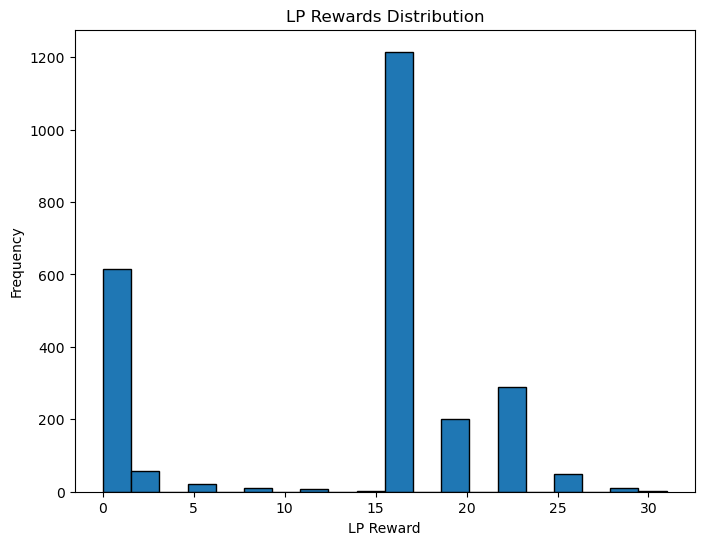

In [ ]:

import matplotlib.pyplot as plt

# Plot a histogram to visualize the distribution of LP rewards
plt.figure(figsize=(8, 6))
plt.hist(lp_rewards_df['LP Reward'], bins=20, edgecolor='black')
plt.xlabel('LP Reward')
plt.ylabel('Frequency')
plt.title('LP Rewards Distribution')
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Concatenate LP scores from borrow_df, deposit_df, and repayment_df
lp_scores = pd.concat([borrow_df['LP Score'], deposit_df['LP Score'], repayment_df['LP Score']])

# Plot a histogram to visualize the LP score distribution
plt.hist(lp_scores, bins=20, edgecolor='k')
plt.xlabel('LP Score')
plt.ylabel('Frequency')
plt.title('LP Score Distribution')
plt.show()


KeyError: 'LP Score'

In [ ]:


# Merge the dataframes by 'Address' column
merged_df2 = pd.merge(deposit_df, deposit_time_df, on='Address', how='outer')
merged_df2 = pd.merge(merged_df2, borrow_df, on='Address', how='outer')
merged_df2 = pd.merge(merged_df2, borrow_time_df, on='Address', how='outer')
merged_df2 = pd.merge(merged_df2, repayment_df, on='Address', how='outer')

# Print the merged dataframe
print("Merged Dataframes:")
merged_df2.iloc[1000:1300]



Merged Dataframes:


,Address,Value_IN(ETH)_x,Deposit Value Score,DateTime_x,Deposit Time Score,Value_OUT(ETH),Borrow Value Score,DateTime_y,Borrow Time Score,Value_IN(ETH)_y,Repayment Value Score
1000,0x99f872252219d4960cab6a35f08d92d7a071c961,0.000001,10,13/09/2022 17:49,70,NaN,NaN,NaN,NaN,NaN,NaN
1001,0x99fdd2a67ba5ec9fb98f451f0e88d0fbec1ee121,0.000500,10,12/09/2022 12:59,70,NaN,NaN,NaN,NaN,NaN,NaN
1002,0x9a2702921fb79a7a3683366bab972736e59bcf6d,0.003000,10,10/09/2022 09:13,70,NaN,NaN,NaN,NaN,NaN,NaN
1003,0x9a6aeb5ffb938b2f0faf83a1f1ec1930e2601506,0.000100,10,09/09/2022 03:02,70,NaN,NaN,NaN,NaN,NaN,NaN
1004,0x9a6f26e92bd22f2e05ea7a0940e675697c2cd8b9,0.000100,10,14/09/2022 08:32,70,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1295,0xc89b1bae0d9acfea70d839c77b64a248e20d1578,0.001473,10,07/09/2022 13:35,100,NaN,NaN,NaN,NaN,NaN,NaN
1296,0xc8b22b908c83f43590eb181b4e3ebb1887c6f8bc,0.000001,10,08/09/2022 13:17,70,NaN,NaN,NaN,NaN,NaN,NaN
1297,0xc8e30e3d9ccaaab5c6b6a764f56268c2459c6f47,0.009000,10,09/09/2022 18:49,70,NaN,NaN,NaN,NaN,NaN,NaN
1298,0xc8e32ba6c504a7b75db73acd6db49842a9b6e02d,0.025310,10,13/09/2022 10:01,70,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:

borrow_df.head()

,Address,Value_OUT(ETH),Borrow Value Score
0,0x0025500c6a6bcaebde159db6a307f4d38503a079,0,10
0,0x032e9ea7e5ca19937c06cfa101b5bb1b55150910,0,10
0,0x0351b0b81fdd1db5dad0617d97c598cd3c37baaf,0,10
0,0x04f2c60d181d3255968a86a0fc76c524265e200c,0,10
0,0x06cacac9b62daad2cc8869b96ab6c61f7d489d68,0,10


In [ ]:
data[data['From']=='0x0025500c6a6bcaebde159db6a307f4d38503a079']

,Txhash,Blockno,UnixTimestamp,DateTime,From,To,ContractAddress,Value_IN(ETH),Value_OUT(ETH),CurrentValue @ $1869.43/Eth,TxnFee(ETH),TxnFee(USD),Historical $Price/Eth,Method
3394,0xd9658342c6b044f4191b3e4b6b7f71ec53dfb85f2dfc...,23190840,1663207451,15/09/2022 02:04,0x0025500c6a6bcaebde159db6a307f4d38503a079,0x76d3030728e52deb8848d5613abade88441cbc59,NaN,0.000000,0,0.000000,0.000057,0.106505,1472.51,Borrow ETH
3630,0x5fa5f785837e8756a9c0c96e9b1f65e870c49fb05287...,23281940,1663249321,15/09/2022 13:42,0x0025500c6a6bcaebde159db6a307f4d38503a079,0x76d3030728e52deb8848d5613abade88441cbc59,NaN,8.000000,0,14955.440000,0.000055,0.101955,1472.51,Repay ETH
3631,0xa75a7af298eaa9ccb68a2adddaaf9bd1e2abf2e5d211...,23282048,1663249366,15/09/2022 13:42,0x0025500c6a6bcaebde159db6a307f4d38503a079,0x76d3030728e52deb8848d5613abade88441cbc59,NaN,0.001119,0,2.091475,0.000057,0.107375,1472.51,Repay ETH


In [ ]:
repayment_df[repayment_df['Address']=='0x0025500c6a6bcaebde159db6a307f4d38503a079']

,Address,Value_IN(ETH),Repayment Value Score
